<a href="https://colab.research.google.com/github/erinijapranckeviciene/MF54609_18981_1_20241/blob/main/FC_book_Ch_12_DeepDream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Generative deep learning

## 12.2.1 Implementing DeepDream in Keras

### Listing 12.9 Fetching the test image

440742/440742 ━━━━━━━━━━━━━━━━━━━━ 1s 2us/step


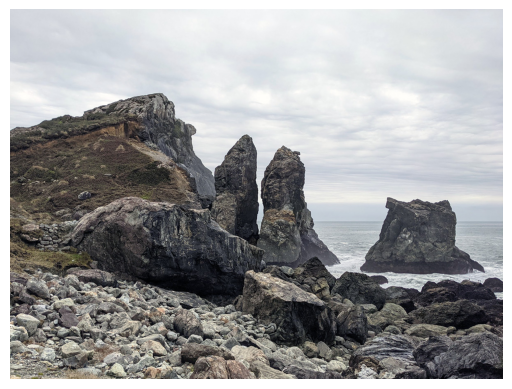

In [ ]:
from tensorflow import keras
import matplotlib.pyplot as plt

base_image_path = keras.utils.get_file("coast.jpg", origin="https://img-datasets.s3.amazonaws.com/coast.jpg")
plt.axis("off")
plt.imshow(keras.utils.load_img(base_image_path))

### Listing 12.10 Instantiating a pretrained InceptionV3 model

Next, we need a pretrained convnet. In Keras, many such convnets are available:
VGG16, VGG19, Xception, ResNet50, and so on, all available with weights pretrained
on ImageNet. You can implement DeepDream with any of them, but your base model
of choice will naturally affect your visualizations, because different architectures result
in different learned features. The convnet used in the original DeepDream release
was an Inception model, and in practice, Inception is known to produce nice-looking
DeepDreams, so we’ll use the Inception V3 model that comes with Keras.

In [ ]:
from tensorflow.keras.applications import inception_v3
model = inception_v3.InceptionV3(weights="imagenet", include_top=False)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


### Listing 12.11 Configuring the contribution of each layer to the DeepDream loss

We’ll use our pretrained convnet to create a feature exactor model that returns the
activations of the various intermediate layers, listed in the following code. For each
layer, we pick a scalar score that weights the contribution of the layer to the loss we will
seek to maximize during the gradient ascent process. If you want a complete list of
layer names that you can use to pick new layers to play with, just use model.summary().

In [ ]:
layer_settings = {
    "mixed4": 1.0,
    "mixed5": 1.5,
    "mixed6": 2.0,
    "mixed7": 2.5,
}

outputs_dict = dict([(layer.name, layer.output)
                     for layer in [model.get_layer(name) for name in layer_settings.keys()]])
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)


### Listing 12.12 The DeepDream loss

In [ ]:
def compute_loss(input_image):
  features = feature_extractor(input_image)
  loss = tf.zeros(shape=())
  for name in features.keys():
    coeff = layer_settings[name]
    activation = features[name]
    loss += coeff * tf.reduce_mean(tf.square(activation[:, 2:-2, 2:-2, :]))
  return loss

### Listing 12.13 The DeepDream gradient ascent process

In [ ]:
import tensorflow as tf

@tf.function
def gradient_ascent_step(image, learning_rate):
  with tf.GradientTape() as tape:
    tape.watch(image)
    loss = compute_loss(image)
  grads = tape.gradient(loss, image)
  grads = tf.math.l2_normalize(grads)
  image += learning_rate * grads
  return loss, image

def gradient_ascent_loop(image, iterations, learning_rate, max_loss=None):
  for i in range(iterations):
    loss, image = gradient_ascent_step(image, learning_rate)
    if max_loss is not None and loss > max_loss:
      break
    print("... Loss value at step %d: %.2f" % (i, loss))
  return image



In [ ]:
# parameters
step = 20.
num_octave = 3
octave_scale = 1.4
iterations = 30
max_loss = 15.

### Listing 12.14 Image processing utilities

In [ ]:
import numpy as np

def preprocess_image(image_path):
  img = keras.utils.load_img(image_path)
  img = keras.utils.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = keras.applications.inception_v3.preprocess_input(img)
  return img

def deprocess_image(img):
  img = img.reshape((img.shape[1], img.shape[2], 3))
  img /= 2.0
  img += 0.5
  img *= 255.
  img = np.clip(img, 0, 255).astype("uint8")
  return img


### Listing 12.15 Running gradient ascent over multiple successive "octaves"

In [ ]:
original_img = preprocess_image(base_image_path)
original_shape = original_img.shape[1:3]

successive_shapes = [original_shape]
for i in range(1, num_octave):
  shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
  successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]

shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])

img = tf.identity(original_img)
for i, shape in enumerate(successive_shapes):
  print("Processing octave %d with shape %s" % (i, shape))
  img = tf.image.resize(img, shape)
  img = gradient_ascent_loop(img, iterations=iterations, learning_rate=step, max_loss=max_loss)
  upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
  same_size_original = tf.image.resize(original_img, shape)
  lost_detail = same_size_original - upscaled_shrunk_original_img
  img += lost_detail
  shrunk_original_img = tf.image.resize(original_img, shape)

keras.utils.save_img("dream.png", deprocess_image(img.numpy()))



Processing octave 0 with shape (459, 612)
... Loss value at step 0: 0.80
... Loss value at step 1: 1.07
... Loss value at step 2: 1.44
... Loss value at step 3: 1.82
... Loss value at step 4: 2.16
... Loss value at step 5: 2.49
... Loss value at step 6: 2.85
... Loss value at step 7: 3.18
... Loss value at step 8: 3.55
... Loss value at step 9: 3.89
... Loss value at step 10: 4.25
... Loss value at step 11: 4.59
... Loss value at step 12: 4.95
... Loss value at step 13: 5.33
... Loss value at step 14: 5.66
... Loss value at step 15: 6.03
... Loss value at step 16: 6.36
... Loss value at step 17: 6.68
... Loss value at step 18: 7.03
... Loss value at step 19: 7.33
... Loss value at step 20: 7.66
... Loss value at step 21: 8.01
... Loss value at step 22: 8.28
... Loss value at step 23: 8.61
... Loss value at step 24: 8.90
... Loss value at step 25: 9.19
... Loss value at step 26: 9.49
... Loss value at step 27: 9.74
... Loss value at step 28: 10.04
... Loss value at step 29: 10.29
Proces

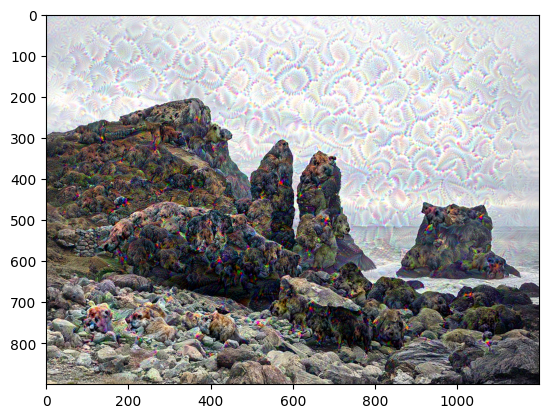

In [ ]:
plt.imshow(keras.utils.load_img("dream.png"))

## TASK. Explore more effects by varying parameters.